<a id='TOC'>

### Банки — Анализ оттока клиентов


**Данные**:    
* Данные о клиентах "Метанпромбанка", который располагается в Ярославле и областных городах: Ростов Великий и Рыбинск 

**Задача**:  
* Составить портрет пользователя склонного к оттоку
* Предложить рекомендации по удержанию клиентов 

### Выводы и рекомендации:
#### Выводы
* Использует только один продукта банка
* Возраст 35-65, максимальный уровень оттока у клиентов 50-58 лет
* Не активен
* На счету либо сравнительно небольшой >50 тыс, либо сравнительно большой < 180 тыс баланс
* Женского пола  
>Отдельно нужно выделить город Ростов Великий, так как **там 1/4 всех клиентов, и самый большой отток**, возможно в этом отделении банка какие-то проблемы с уровнем обслуживания, либо есть конкурент с более выгодными условиями, что маловероятно, т.к город небольшой ~ 30 тыс. население
#### Рекомендации
* Нужны дополнительные данные для анализа причин высокого оттока в отделении банка в Ростове Великом
* Разработать программу лояльности для клиентов женского пола
   * увеличенные скидки или кэшбек в салоны красоты, магазины одежды и обуви, товаров для дома и т.д.
* В целом нужно стараться повышать количество продуктов банка, используемых клиентами и активность:
   * полезные сервисы и услуги
   * повышенный процент по остатку на счете за выполнение определенных условий
* Повышать персонализацию обслуживания для клиентов старше 45 и с большим балансом

>**Содержание:**  
1. [Описание данных и декомпозиция](#description_decomposition)
2. [Предобработка](#pretreatment)
3. [Исследовательский анализ данных (EDA)](#eda)
4. [Статистические гипотезы](#stat)   
5. [Машинное обучение](#ml)
6. [Источники (документация)](#references)

* [Портрет клиента склонного к оттоку](#churn_features)
* [Выводы и рекомендации](#conclusions)

### 2. Предобработка данных
<a id='pretreatment'>

In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
from scipy import stats as st
import math

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# Задание параметров для графиков в seaborn
plt.style.use('tableau-colorblind10')
sns.set_palette('colorblind')
sns.set_context("talk")
# Своя палитра
my_palette = ['#e15f41', '#786fa6', '#9b59b6', '#e74c3c', '#7f8c8d']

pd.set_option('display.max_columns', None)
%matplotlib inline

# для полного отображения содержимого столбцов
pd.set_option('display.max_colwidth', -1)

# Библиотеки для машинного обучения
# импорт sklearn и ее методов/алгоритмов
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
path='C:\\Users\\Admin\\YANDEX_PRAKTIKUM\\final_project\\bank_dataset.csv'
df=pd.read_csv(path)

In [3]:
def df_look(df):
    """
    Функция для получения общей информации о датафрейме
    """
    print('Первые 3 строки датафрейма')
    print('-'*52)
    print('{}'.format(df.head(3)))
    print('='*52)
    print('Размер датафрейма: (строк:столбцов) {}'.format(df.shape))
    print('='*52)
    print('Типы данных и общая информация')
    print('-'*52)
    print(df.info())
    print('='*52)
    print('Наличие дубликатов')
    print('='*52)
    print(df.duplicated().sum())
    print('-'*52)
    print('Наличие пропусков')
    print('-'*52)
    print(df.isna().sum())
    print('='*52)

In [4]:
df_look(df)

Первые 3 строки датафрейма
----------------------------------------------------
     userid  score       City Gender  Age  Objects    Balance  NumOfProducts  \
0  15677338  619    Ярославль  Ж      42   2       NaN         1               
1  15690047  608    Рыбинск    Ж      41   1        83807.86   1               
2  15662040  502    Ярославль  Ж      42   8        159660.80  3               

   CreditCard  IsActiveMember  EstimatedSalary  Churn  
0  1           1               101348.88        1      
1  0           1               112542.58        0      
2  1           0               113931.57        1      
Размер датафрейма: (строк:столбцов) (10000, 12)
Типы данных и общая информация
----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
userid             10000 non-null int64
score              10000 non-null int64
City               10000 non-null object
Gender        

* Имеются пропуски в столбце со значением баланса, скорее всего на счету нет денег, однако этот момент нужно, по возможности, уточнить у заказчика, остальные данные в порядке
* нужно переименовать название стобцов

Посмотрим на данные методом `describe()`, для удобства транспонируем таблицу, чтобы названия признаков располагались в одной колонке

In [5]:
df.describe().transpose().round()

,count,mean,std,min,25%,50%,75%,max
userid,10000.0,15733677.0,71936.0,15608437.0,15671264.0,15733474.0,15795970.0,15858426.0
score,10000.0,651.0,97.0,350.0,584.0,652.0,718.0,850.0
Age,10000.0,39.0,10.0,18.0,32.0,37.0,44.0,92.0
Objects,10000.0,5.0,3.0,0.0,3.0,5.0,7.0,10.0
Balance,6383.0,119827.0,30095.0,3769.0,100182.0,119840.0,139512.0,250898.0
NumOfProducts,10000.0,2.0,1.0,1.0,1.0,1.0,2.0,4.0
CreditCard,10000.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
IsActiveMember,10000.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
EstimatedSalary,10000.0,100090.0,57510.0,12.0,51002.0,100194.0,149388.0,199992.0
Churn,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


* Баллы кредитного скоринга: min=350, max=850 
* Средний возраст клиента - 39 лет
* Среднее количество объектов в собственности - 5 (вероятно, это не только недвижимость, но и автомобили и другая собственность)
* Средний баланс ~ 120 000 
* Среднее количество продуктов клиентов - 2 продукта
* Средняя зарплата составляет 100 000 рублей

**Предобработка (замена названий столбцов, заполнение нулями `NaN`-значений в балансе)** 

In [6]:
# формируем список с названиями признаков в нижнем регистре, и переименовываем колонки
lowercase_columns = []
for col in df.columns.tolist():
    col=col.lower()
    lowercase_columns.append(col)
    
df.columns = lowercase_columns
df.head(3)

,userid,score,city,gender,age,objects,balance,numofproducts,creditcard,isactivemember,estimatedsalary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1


In [7]:
new_value = ['user_id', 'score', 'city', 'gender', 
             'age', 'num_of_objects','balance', 
             'num_of_products', 'credit_card', 
             'is_active', 'salary', 'churn']  
df.columns = new_value

In [8]:
df.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'num_of_objects',
       'balance', 'num_of_products', 'credit_card', 'is_active', 'salary',
       'churn'],
      dtype='object')

In [9]:
df['balance'] = df['balance'].fillna(0)

In [10]:
df.head()

,user_id,score,city,gender,age,num_of_objects,balance,num_of_products,credit_card,is_active,salary,churn
0,15677338,619,Ярославль,Ж,42,2,0.00,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,0.00,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


<a id='eda'>

**3. Исследовательский анализ данных** 

Создадим копию предобработанного датафрейма `df_ml` для последующего машинного обучения

In [11]:
df_ml = df.copy()

In [12]:
def feature_hist(data, target_column, all_columns):
    """Функция для построения гистограмм распределения"""
    for column in all_columns:
        for churn_type in data[target_column].unique():
            sns.distplot(data[data[target_column]==churn_type][column],
                         label='{} = {}'.format(churn_type, str(column)), bins = 10)
        plt.title(column)
        plt.legend()
        plt.show()

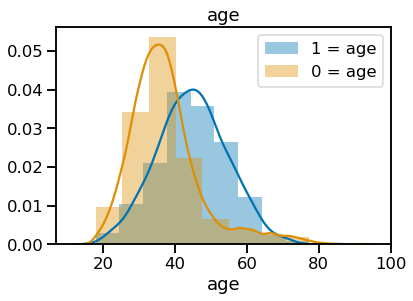

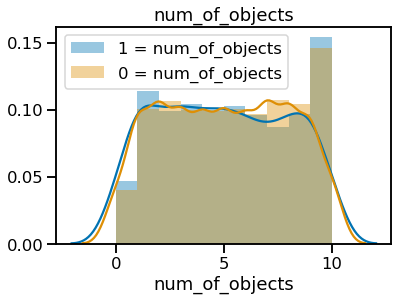

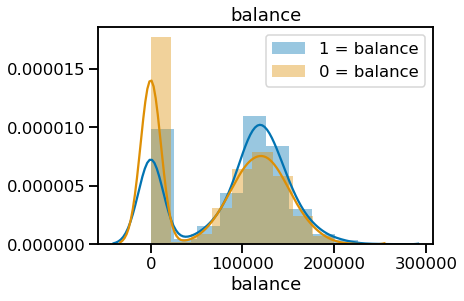

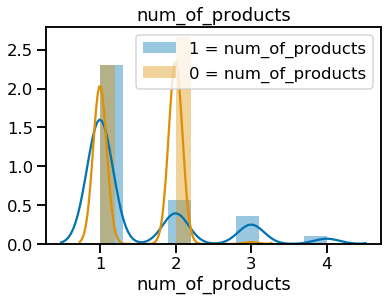

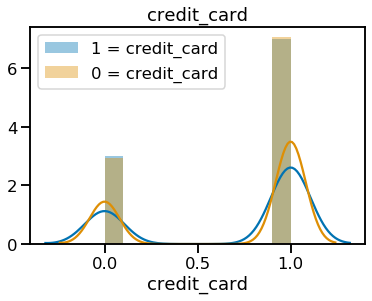

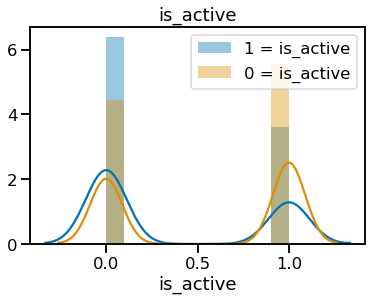

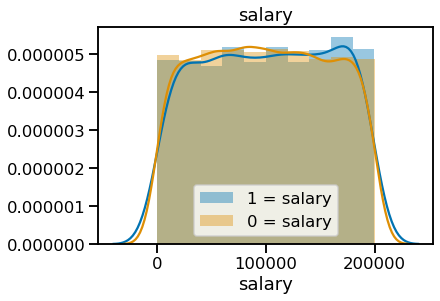

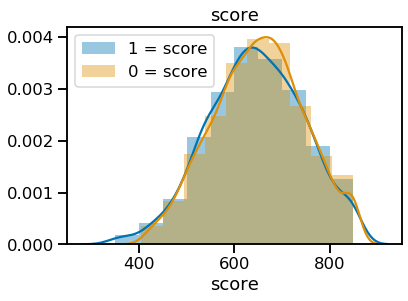

In [13]:
# Формируем список числовых признаков
columns_list = new_value[4:11]
columns_list.append('score')
# Строим гистограммы
feature_hist(df, 'churn', columns_list)

In [14]:
# Посмотрим на категориальные признаки с помощью столбчатой диаграммы
def bar_plot(df,grouping_col, target_col):
    """Функция для построения столбчатой диаграммы"""
    churn_temp = (df
                  .groupby([grouping_col])[target_col]
                  .mean()
                  .reset_index())
    sns.barplot(x=grouping_col, y=target_col, data=churn_temp);


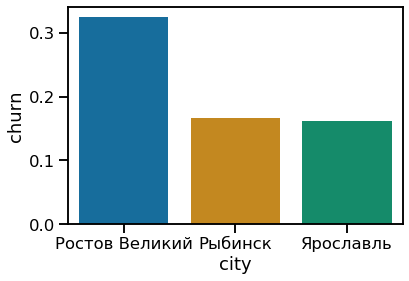

In [15]:
bar_plot(df, 'city', 'churn')

**В Рыбинске и Ярославле примерно одинаковый уровень оттока ~ 17 %, а вот в Ростове Великом более 30%   
Что там не так? Сотрудники хамят клиентам, или появился банк с более выгодными продуктами?**

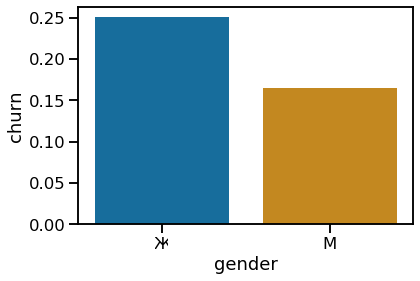

In [16]:
bar_plot(df, 'gender', 'churn')

**Отток выше у клиентов женского пола**

`Посмотрим на средний отток в разрезе городов и пола клиентов`

In [17]:
churn_gr = df.groupby(['city', 'gender'])['churn'].agg(['count', 'mean']).reset_index()

In [18]:
churn_gr

,city,gender,count,mean
0,Ростов Великий,Ж,1193,0.375524
1,Ростов Великий,М,1316,0.278116
2,Рыбинск,Ж,1089,0.212121
3,Рыбинск,М,1388,0.131124
4,Ярославль,Ж,2261,0.203450
5,Ярославль,М,2753,0.127134


In [19]:
# напишем функцию для построения графиков в seaborn
def grafoman(df, kind, x, y, hue, rot, title_name, x_name, y_name, img_name, save):
    """
    grafoman(df, kind, x, y, hue, title_name, x_name, y_name, img_name, save)
    -Строит график (какой задается в параметре kind)
    -Сохраняет график в формате *.png
    
    Принимает на вход датафрейм - df
    kind - тип графика, может принимать значения:
            -'point', 'bar', 'strip', 
            -'swarm', 'box', 'violin', 'boxen'
    x, y - оси графика X и Y, соответственно
    hue - дополнительное информация
          для отображения 
    title_name, x_name, y_name - название графика и осей 
    img_name - название графика для сохранения
               сохраняет в формате *.png (если save==True)
               формат имени файла: 'image_{img_name}'
    save - принимает значение True (сохраняет) или False (не сохраняет)
    график в *.png
    """
    ax=sns.catplot(x=x, y=y, hue=hue, kind=kind, data=df, 
                   palette=my_palette, 
                   height=3.0, aspect=2.5)
    (ax
     .set_xticklabels(rotation=rot)
     .set(title = title_name)
     .set(xlabel = x_name)
     .set(ylabel = y_name)
    )
    
    sns.despine()
    if save==True:
        plt.savefig(f'image_{img_name}.png', bbox_inches='tight', dpi=300, transparent=True)
    else:
        pass;

[1. Документация seaborn](#ref_1)

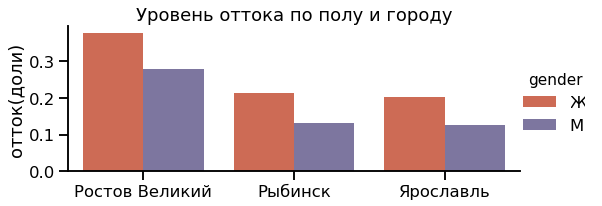

In [20]:
grafoman(churn_gr, 'bar', 'city', 'mean', 'gender', 0, 'Уровень оттока по полу и городу', '', 'отток(доли)', 1, False)

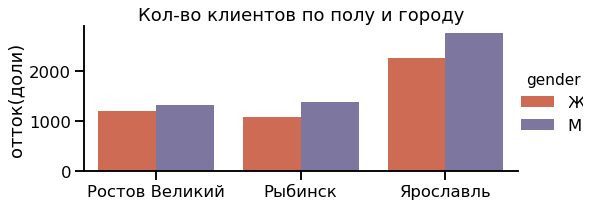

In [21]:
grafoman(churn_gr, 'bar', 'city', 'count', 'gender', 0, 'Кол-во клиентов по полу и городу', '', 'отток(доли)', 2, False)

In [22]:
def client_amount(city_name):
    """Рассчитывает кол-во клиентов в городах присутствия банка"""
    print(f"Количество клиентов банка в {city_name}: {df[df['city']==city_name]['user_id'].count()}")

In [23]:
for name in df['city'].unique().tolist():
    client_amount(name)

Количество клиентов банка в Ярославль: 5014
Количество клиентов банка в Рыбинск: 2477
Количество клиентов банка в Ростов Великий: 2509


In [24]:
186575/30700

6.077361563517916

Больше всего клиентов у "Метанпромбанка" в Ярославле -- это логично, в Ярославле самое большое население по области (609828 чел.) Население Рыбинска (186575 чел.), население Ростова Великого (30700)
Кол-во клиентов в Рыбинске и Ростове почти одинаковое: 2477 и 2509, соответственно, при том что в Ростове население в 6 раз меньше чем в Рыбинске.   
**Ростов Великий это 1/4 всех клиентов банка с уровнем оттока почти в два раза выше чем в других городах Ярославской области**

[2. Статистика по Ярославской области](#ref_2)

In [25]:
print('Количество клиентов женского пола: {}'.format((df[df['gender']=="Ж"]['user_id'].count()/df.shape[0])*100))
print('Количество клиентов мужского пола: {}'.format((df[df['gender']=="М"]['user_id'].count()/df.shape[0])*100))


Количество клиентов женского пола: 45.43
Количество клиентов мужского пола: 54.56999999999999


In [26]:
#print(grafoman.__doc__)

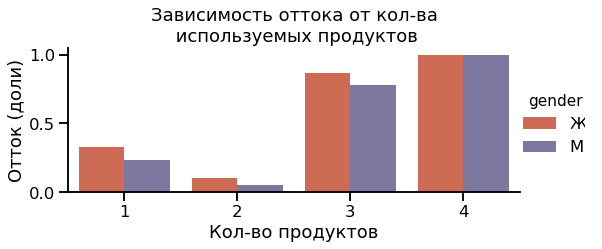

In [27]:
df_num_products = df.groupby(['num_of_products','gender'])['churn'].agg(['count','mean']).reset_index()
grafoman(df_num_products, 'bar', 'num_of_products', 'mean', 'gender', 0, \
         'Зависимость оттока от кол-ва\n используемых продуктов',\
         'Кол-во продуктов', 'Отток (доли)', 3, False)

In [28]:
df_num_products

,num_of_products,gender,count,mean
0,1,Ж,2296,0.331882
1,1,М,2788,0.232066
2,2,Ж,2060,0.101942
3,2,М,2530,0.054545
4,3,Ж,149,0.865772
5,3,М,117,0.777778
6,4,Ж,38,1.000000
7,4,М,22,1.000000


Количество продуктов у клиента важный параметр, влияющий на отток,
причем нужно рассматривать клиентов у которых 1 или 2 банковских продукта. Доля тех у кого 3 и 4 продукта небольшая

Разделим клиентов по уровню баланса 


In [29]:
df['balance_cat'] = pd.cut(df['balance'], bins=np.linspace(0, 251000, 20))

[3. Использование фун-ций `pd.cut()` и `np.linspace()`](#ref_3)

In [30]:
df.head()

,user_id,score,city,gender,age,num_of_objects,balance,num_of_products,credit_card,is_active,salary,churn,balance_cat
0,15677338,619,Ярославль,Ж,42,2,0.00,1,1,1,101348.88,1,NaN
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,"(79263.158, 92473.684]"
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,"(158526.316, 171736.842]"
3,15744090,699,Ярославль,Ж,39,1,0.00,2,0,0,93826.63,0,NaN
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,"(118894.737, 132105.263]"


In [31]:
df_balance = df.groupby(['balance_cat','gender'])['churn'].mean().reset_index()#.plot(rot=60, figsize=(15, 7));

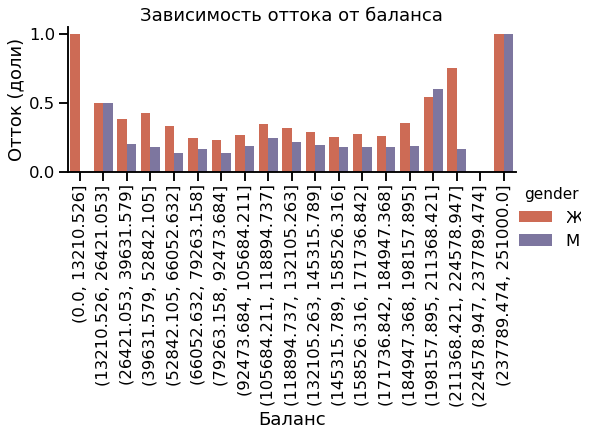

In [32]:
grafoman(df_balance, 'bar', 'balance_cat', 'churn', 'gender', 90, \
         'Зависимость оттока от баланса',\
         'Баланс', 'Отток (доли)', 4, False)

Отток клиентов расчет с увеличением баланса на счете

In [33]:
df['age_cat'] = pd.cut(df['age'], bins=np.linspace(17, 92, 10))

In [34]:
df_age = df.groupby(['age_cat','gender'])['churn'].mean().reset_index()#.plot(rot=60, figsize=(15, 7));

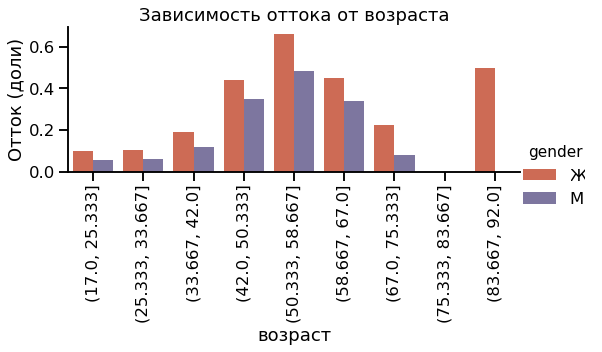

In [35]:
grafoman(df_age, 'bar', 'age_cat', 'churn', 'gender', 90, \
         'Зависимость оттока от возраста',\
         'возраст', 'Отток (доли)', 5, False)

In [36]:
df['salary_cat'] = pd.cut(df['salary'], bins=np.linspace(0, 200000, 10))
df_salary = df.groupby(['salary_cat','gender'])['churn'].mean().reset_index()

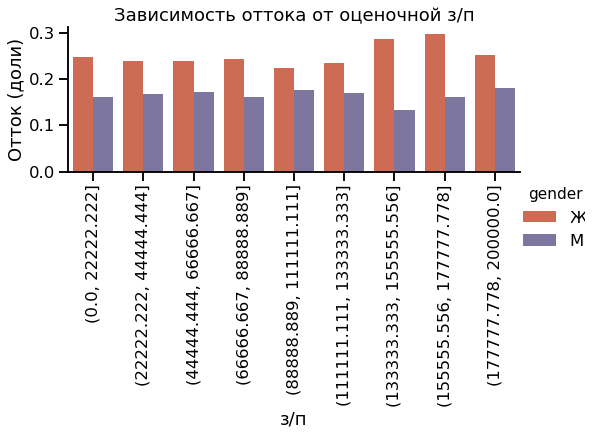

In [37]:
grafoman(df_salary, 'bar', 'salary_cat', 'churn', 'gender', 90, \
         'Зависимость оттока от оценочной з/п',\
         'з/п', 'Отток (доли)', 6, False)

In [38]:
df['score_cat'] = pd.cut(df['score'], bins=np.linspace(350, 850, 10))
df_score = df.groupby(['score_cat','gender'])['churn'].mean().reset_index()

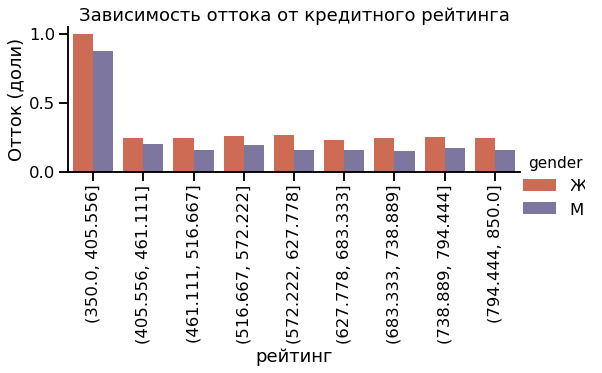

In [39]:
grafoman(df_score, 'bar', 'score_cat', 'churn', 'gender', 90, \
         'Зависимость оттока от кредитного рейтинга',\
         'рейтинг', 'Отток (доли)', 7, False)

**Посмотрим как влияет на отток наличие/отсутствие кредитной карты и активность клиента**

In [40]:
df.groupby(['credit_card'])['churn'].mean()

credit_card
0    0.208149
1    0.201843
Name: churn, dtype: float64

In [41]:
df.groupby(['is_active'])['churn'].mean()

is_active
0    0.268509
1    0.142691
Name: churn, dtype: float64

* наличие/отсутствие кредитной карты не влияет на отток
* уровень оттока активных клиентов почти в два раза ниже чем неактивных

**Построим матрицу корреляций числовых признаков**

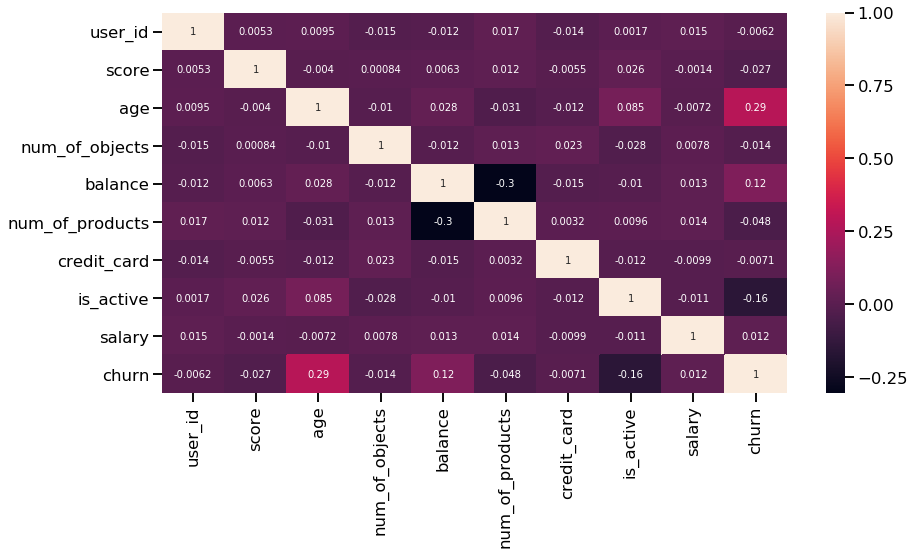

In [42]:
corr = df.corr()
f, ax = plt.subplots(figsize=(14, 7))
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True);

По матрице корреляций самые важные признаки, влияющие на отток:
  * возраст
  * баланс
  * активность клиента  
Количество используемых продуктов банка показывает слабую корреляцию с оттоком, хотя выше было показано что это не так.

<a id='stat'>

### 3. Статистические гипотезы

**Выделение портретов клиентов, склонных к уходу из банка**
* Сегментировать пользователей на основании результатов EDA (выделение портретов склонных к уходу из банка)
* Сформулировать и проверить статистические гипотезы о равенстве средних значений:
     * Оттока у клиентов которые пользуются одним и двумя банковскими продуктами
     * Оттока у клиентов с одним и двумя объектами в собственности
     * Уровня зарплаты у тех, кто остался и тех, кто ушел

In [43]:
# Функция для проверки p-value
def ttest_independent(df1, df2):
    """Фун-ция для проверки стат.гипотез (t-test Стьюдента)"""
    alpha = 0.05
    results = st.ttest_ind(df1, df2)
    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу, p-value:", results.pvalue)
    else:
        print("Не получилось отвергнуть нулевую гипотезу,  p-value:", results.pvalue)

In [44]:
def mw_test(df1, df2):
    """Фун-ция для проверки стат.гипотез (критерий Манна-Уитни)"""
    alpha = 0.05
    results = st.mannwhitneyu(df1, df2)
    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу, p-value:", results.pvalue)
    else:
        print("Не получилось отвергнуть нулевую гипотезу,  p-value:", results.pvalue)

In [45]:

def full_test(df1, df2):
    """Фун-ция для проверки распределения на нормальность и выбора критерия
       в зависимости от результата: нормальное распределение - t-test Стьюдента
       ненормальное - критерий Манна-Уитни
    """
    alpha = 0.05
    sh_test_result_df1 = st.shapiro(df1)
    sh_test_result_df2 = st.shapiro(df2)
    if sh_test_result_df1[1] < alpha or sh_test_result_df2[1] < alpha:
        print(f'По результатам теста Шапиро-Уилка, p-value={sh_test_result_df1[1]} распределение не нормальное\n используем критерий Манна-Уитни')
        print("="*80)
        mw_test(df1, df2)
    else:
        print(f'Распределение нормальное, используем t-test')
        ttest_independent(df1, df2)

**Отток у клиентов которые пользуются одним и двумя банковскими продуктами**
>`AC - average churn`

>**H0: `AC(num_of_products==1) = AC(num_of_products==2)`**

In [46]:
df_1_prod = df[df['num_of_products']==1]['churn']
df_2_prod = df[df['num_of_products']==2]['churn']

full_test(df_1_prod, df_2_prod)

По результатам теста Шапиро-Уилка, p-value=0.0 распределение не нормальное
 используем критерий Манна-Уитни
Отвергаем нулевую гипотезу, p-value: 2.3223711627553688e-145


**Уверенно отвергаем нулевую гипотезу, уровень оттока у клиентов с 1 и 2 продуктами значимо различается**

-----------------------------------------
**Отток у клиентов с одним и двумя объектами в собственности**

>**H0: `AC(num_of_objects==1) = AC(num_of_objects==2)`**

In [47]:
df_1_obj = df[df['num_of_objects']==1]['churn']
df_2_obj = df[df['num_of_objects']==2]['churn']

full_test(df_1_obj, df_2_obj)

По результатам теста Шапиро-Уилка, p-value=0.0 распределение не нормальное
 используем критерий Манна-Уитни
Отвергаем нулевую гипотезу, p-value: 0.03443078536038547


**При уровне значимости `alpha = 0.01` мы бы не смогли отвергнуть нулевую гипотезу, будем считать что уровень оттока у клиентов с 1 и 2 объектами в собственности одинаковый**

--------------------------------
**Уровень зарплаты у тех, кто остался и тех, кто ушел**

>`AS - average salary`

>**H0: `AS(churn==0) = AC(churn==1)`**

In [48]:
df_salary_churn = df[df['churn']==1]['salary']
df_salary_nonchurn = df[df['churn']==0]['salary']

full_test(df_salary_churn, df_salary_nonchurn)

По результатам теста Шапиро-Уилка, p-value=4.594104044877579e-25 распределение не нормальное
 используем критерий Манна-Уитни
Не получилось отвергнуть нулевую гипотезу,  p-value: 0.11352575465076892


**Уровень "оценочной" зарплаты у тех кто ушел, и тех кто остался одинаковый**

**Проверим аналогичные гипотезы о равенстве средних: возраста, кредитного рейтинга,  активности, и баланса у тех кто ушел, и тех кто остался** 

* age
* score
* is_active
* balancе


In [49]:
df_age_churn = df[df['churn']==1]['age']
df_age_nonchurn = df[df['churn']==0]['age']

full_test(df_age_churn, df_age_nonchurn)

По результатам теста Шапиро-Уилка, p-value=0.005956501234322786 распределение не нормальное
 используем критерий Манна-Уитни
Отвергаем нулевую гипотезу, p-value: 1.6052007159685838e-230


**средний возраст "отточных" и "неотточных" клиентов значимо различается**

In [50]:
df_score_churn = df[df['churn']==1]['score']
df_score_nonchurn = df[df['churn']==0]['score']

full_test(df_score_churn, df_score_nonchurn)

По результатам теста Шапиро-Уилка, p-value=1.2323278042458696e-07 распределение не нормальное
 используем критерий Манна-Уитни
Отвергаем нулевую гипотезу, p-value: 0.00993433058636417


**В данном случае `p-value близок к 0,01` и при таком уровне значимости мы бы не смогли отвергнуть нулевую гипотезу  
кредитный рейтинг значимо не влияет на отток**

In [51]:
df_active_churn = df[df['churn']==1]['is_active']
df_active_nonchurn = df[df['churn']==0]['is_active']

full_test(df_active_churn, df_active_nonchurn)

По результатам теста Шапиро-Уилка, p-value=0.0 распределение не нормальное
 используем критерий Манна-Уитни
Отвергаем нулевую гипотезу, p-value: 3.0138152767839447e-55


In [52]:
df_balance_churn = df[df['churn']==1]['balance']
df_balance_nonchurn = df[df['churn']==0]['balance']

full_test(df_balance_churn, df_balance_nonchurn)

По результатам теста Шапиро-Уилка, p-value=3.2270264114197277e-38 распределение не нормальное
 используем критерий Манна-Уитни
Отвергаем нулевую гипотезу, p-value: 5.579199689574611e-29


Дополнительно проверим гипотезу о равенстве средних значений оттока у клиентов-мужчин и клиентов-женщин

In [53]:
df_gender_female = df[df['gender']=="Ж"]['churn']
df_gender_male = df[df['gender']=='М']['churn']

mw_test(df_gender_female, df_gender_male)

Отвергаем нулевую гипотезу, p-value: 8.65189721860455e-27


In [54]:
df.head()

,user_id,score,city,gender,age,num_of_objects,balance,num_of_products,credit_card,is_active,salary,churn,balance_cat,age_cat,salary_cat,score_cat
0,15677338,619,Ярославль,Ж,42,2,0.00,1,1,1,101348.88,1,NaN,"(33.667, 42.0]","(88888.889, 111111.111]","(572.222, 627.778]"
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,"(79263.158, 92473.684]","(33.667, 42.0]","(111111.111, 133333.333]","(572.222, 627.778]"
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,"(158526.316, 171736.842]","(33.667, 42.0]","(111111.111, 133333.333]","(461.111, 516.667]"
3,15744090,699,Ярославль,Ж,39,1,0.00,2,0,0,93826.63,0,NaN,"(33.667, 42.0]","(88888.889, 111111.111]","(683.333, 738.889]"
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,"(118894.737, 132105.263]","(42.0, 50.333]","(66666.667, 88888.889]","(794.444, 850.0]"


**Баланс на счете и активность клиента значимо влияют на отток**
<a id='churn_features'>

>**Портрет клиента "Метанпромбанка" склонного к оттоку:**
* Использует только один продукта банка
* Возраст 35-65, максимальный уровень оттока у клиентов 50-58 лет
* Не активен
* На счету либо сравнительно небольшой >50 тыс, либо сравнительно большой < 180 тыс баланс
* Женского пола  
>Отдельно нужно выделить город Ростов Великий, так как **там 1/4 всех клиентов, и самый большой отток**, возможно в этом отделении банка какие-то проблемы с уровнем обслуживания, либо есть конкурент с более выгодными условиями, что маловероятно, т.к город небольшой ~ 30 тыс. население

<a id='ml'>

### 5. Машинное обучение

In [55]:
df_ml.head()

,user_id,score,city,gender,age,num_of_objects,balance,num_of_products,credit_card,is_active,salary,churn
0,15677338,619,Ярославль,Ж,42,2,0.00,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,0.00,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


* Заменим пол на 1 для мужчин и 0 для женщин.
* Название городов на `латиницу` 
* для преобразования (векторизации) названия городов в бинарные признаки применим метод `get_dummies()`

In [56]:
def replacer (df, col, old_value, new_value):
    """
    Производит замену значений в столбцах
    переменные: df, col, old_value, new_value
    """
    for i in col:
        df[col] = df[col].replace(old_value, new_value)

In [57]:
df_ml['city'].unique().tolist()

['Ярославль', 'Рыбинск', 'Ростов Великий']

In [58]:
# заменим и преобразуем данные
replacer(df_ml, 'gender', ['М', 'Ж'], ['1', '0'])
df_ml['gender'] = df_ml['gender'].astype('int64')
# переименуем города
replacer(df_ml, 'city', ['Ярославль', 'Рыбинск', 'Ростов Великий'], ['yaroslavl', 'rybinsk','rostov'])

# удалим лишний числовой признак "user_id"
df_ml.drop(['user_id'], axis=1, inplace=True)

# векторизуем города
df_ml = pd.get_dummies(df_ml)

[4. Использование метода `get_dummies()`](#ref_4) 


In [59]:
df_ml.head(3)

,score,gender,age,num_of_objects,balance,num_of_products,credit_card,is_active,salary,churn,city_rostov,city_rybinsk,city_yaroslavl
0,619,0,42,2,0.00,1,1,1,101348.88,1,0,0,1
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,0,0,1


**Разделяем признаки и целевую переменную**

In [60]:
# X - признаки
features = df_ml.drop(['churn'], axis=1)
# y - целевая переменная
target = df_ml['churn']

In [61]:
# features_train - X_train; features_valid - X_test; target_train - y_train; target_valid - y_test
features_train, features_valid, target_train, target_valid = train_test_split(features,target, test_size=0.2, random_state=42)

In [62]:
# Обучаем модель логистической регрессии
lr_model = LogisticRegression(random_state=42)
lr_model.fit(features_train, target_train)
pred_valid = lr_model.predict(features_valid)
lr_mse = mean_squared_error(target_valid, pred_valid)
lr_rmse = math.sqrt(lr_mse)

In [63]:
# выводим метрики 
print('Логистическая регрессия')
print('='*len('Логистическая регрессия'))
print('RMSE_linear:', lr_rmse)
print('Accuracy:', accuracy_score(target_valid, pred_valid))
print('Precision:', precision_score(target_valid, pred_valid))
print('Recall:', recall_score(target_valid, pred_valid))
print('F1:', f1_score(target_valid, pred_valid))

Логистическая регрессия
RMSE_linear: 0.4455333881989093
Accuracy: 0.8015
Precision: 0.46774193548387094
Recall: 0.0737913486005089
F1: 0.12747252747252746


In [64]:
# обучаем модель "случайный лес"
# объявляем пустой список, в который будут записываться метрики
rf_metrics = []
for estimator in range(5, 100, 10):
    for i in range(1,11,1):
        rf_model = RandomForestClassifier(n_estimators=estimator, max_depth=i, random_state=42)
        rf_model.fit(features_train, target_train)
        pred_valid = rf_model.predict(features_valid)
        rf_mse = mean_squared_error(target_valid, pred_valid)
        rf_rmse = math.sqrt(rf_mse)
        # записываем метрики
        rf_metrics.append([estimator, i, 
                              rf_rmse,
                              accuracy_score(target_valid, pred_valid),
                              precision_score(target_valid, pred_valid),
                              recall_score(target_valid, pred_valid),
                              f1_score(target_valid, pred_valid)])

In [65]:
# формируем датафрейм из списка "rf_metrics"
df_rf_metrics = pd.DataFrame(rf_metrics)
# переименовываем колонки
df_rf_metrics.columns = ['n_estimators', 'max_depth', 'rmse',
                         'accuracy', 'precision', 'recall', 'f1']
# выводим общую информацию о датафрейме
df_rf_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
n_estimators    100 non-null int64
max_depth       100 non-null int64
rmse            100 non-null float64
accuracy        100 non-null float64
precision       100 non-null float64
recall          100 non-null float64
f1              100 non-null float64
dtypes: float64(5), int64(2)
memory usage: 5.5 KB


In [66]:
# выводим 3 модели с наибольшим значеним f1
df_rf_metrics.sort_values(by='f1', ascending=False).head(3)

,n_estimators,max_depth,rmse,accuracy,precision,recall,f1
17,15,8,0.366742,0.8655,0.767241,0.452926,0.569600
49,45,10,0.367423,0.8650,0.766234,0.450382,0.567308
78,75,9,0.367423,0.8650,0.768559,0.447837,0.565916


In [67]:
# выводим 3 модели с наименьшим значеним rmse
df_rf_metrics.sort_values(by='rmse', ascending=True).head(3)

,n_estimators,max_depth,rmse,accuracy,precision,recall,f1
37,35,8,0.366742,0.8655,0.781818,0.437659,0.561175
27,25,8,0.366742,0.8655,0.774336,0.445293,0.565428
17,15,8,0.366742,0.8655,0.767241,0.452926,0.569600


In [68]:
# выведем модели по условию минимального rmse и максимального f1
rmse_min = df_rf_metrics['rmse'].min()
f1_max = df_rf_metrics['f1'].max()
df_rf_metrics.query('rmse==@rmse_min and f1==@f1_max')

,n_estimators,max_depth,rmse,accuracy,precision,recall,f1
17,15,8,0.366742,0.8655,0.767241,0.452926,0.5696


**Посмотрим какие гиперпараметры будут получены при кросс-валидации**  
С помощью `GridSearchCV`

[5. Использование `GridSearchCV` для нахождения оптимальных параметров](#ref_5)

In [69]:
from sklearn.model_selection import GridSearchCV, cross_val_score

forest = RandomForestClassifier(n_estimators=100, random_state=42)

forest_params = {'max_depth':range(1,11), 'n_estimators':[5, 15, 25, 35, 45, 65]}
scoring={'F1':'f1', 'MSE':make_scorer(mean_squared_error)}

forest_grid = GridSearchCV(forest, forest_params, cv=5, verbose=True,\
                           scoring=scoring,\
                           refit='F1')

In [71]:
forest_grid.fit(features_train, target_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max

In [72]:
forest_grid.best_params_,forest_grid.best_score_

({'max_depth': 10, 'n_estimators': 35}, 0.5670259742231841)

>**Лучше всего модель "случайный лес"
со следующими гиперпараметрами**:
>
* **n_estimators = 15**
* **max_depth = 8**


**Проведем кластеризацию пользователей с помощью алгоритма `K-Means`**

In [73]:
# стандартизаруем данные, удаляем столбец с целевой переменной
sc = StandardScaler()
data=df_ml.drop('churn', axis=1)
x_sc=sc.fit_transform(data)

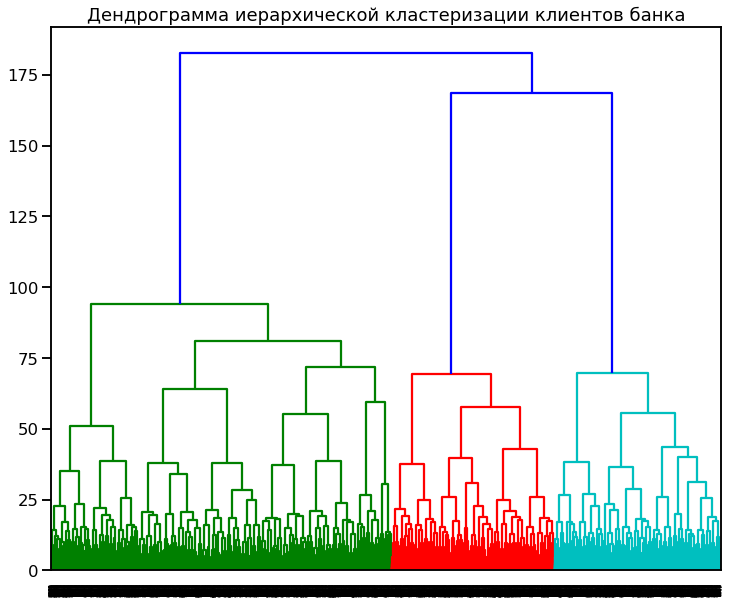

In [74]:
# строим дендрограмму 
plt.figure(figsize=(12,10))
linked = linkage(x_sc, method='ward')
dendrogram(linked, orientation='top')
plt.title('Дендрограмма иерархической кластеризации клиентов банка')
plt.show()

**Выделяем по цвету 3 кластера клиентов**

In [75]:
# стандартизируем данные, обучаем модель
sc_km = StandardScaler()
x_sc_km = sc_km.fit_transform(df_ml)
# строим прогноз
km = KMeans(n_clusters=3, random_state=42)
labels = km.fit_predict(x_sc_km)
# добавляем столбец с кластерами и группируем по кластерам, находим среднее
df_ml['cluster_km'] = labels
clusters_grouped = df_ml.groupby('cluster_km').mean()

In [76]:
df_ml.head()

,score,gender,age,num_of_objects,balance,num_of_products,credit_card,is_active,salary,churn,city_rostov,city_rybinsk,city_yaroslavl,cluster_km
0,619,0,42,2,0.00,1,1,1,101348.88,1,0,0,1,2
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,1,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,0,0,1,2
3,699,0,39,1,0.00,2,0,0,93826.63,0,0,0,1,2
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,1,0,1


In [77]:
# транспонируем сгруппированную таблицу, переименовываем кластеры
clusters_grouped_new = clusters_grouped.transpose()
clusters_grouped_new.columns = ['cluster_1', 'cluster_2', 'cluster_3']
clusters_grouped_new

,cluster_1,cluster_2,cluster_3
score,651.453567,651.333872,649.668329
gender,0.524512,0.560355,0.549063
age,39.771622,38.890997,38.511767
num_of_objects,5.009964,5.032297,5.004587
balance,119730.116134,61818.147763,62092.636516
num_of_products,1.519729,1.539362,1.530913
credit_card,0.713830,0.694792,0.706621
is_active,0.497409,0.529673,0.516753
salary,101113.435102,99440.572281,99899.180814
churn,0.324432,0.166734,0.161548


In [78]:
# копируем датафрейм и заменяем цифровое обозначение кластера на категориальное
cluster_df = df_ml.copy()
replacer(cluster_df, 'cluster_km', [0, 1, 2], ['cluster_1', 'cluster_2', 'cluster_3'])

In [79]:
cluster_df.head()

,score,gender,age,num_of_objects,balance,num_of_products,credit_card,is_active,salary,churn,city_rostov,city_rybinsk,city_yaroslavl,cluster_km
0,619,0,42,2,0.00,1,1,1,101348.88,1,0,0,1,cluster_3
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,1,0,cluster_2
2,502,0,42,8,159660.80,3,1,0,113931.57,1,0,0,1,cluster_3
3,699,0,39,1,0.00,2,0,0,93826.63,0,0,0,1,cluster_3
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,1,0,cluster_2


In [80]:
def amount(df, cluster):
    print(f'Доля кластера {cluster}:', (df.query('cluster_km==@cluster').shape[0]/df.shape[0])*100, '%')
 
clusters = ['cluster_1', 'cluster_2', 'cluster_3']

for i in clusters:
    amount(cluster_df, i)

Доля кластера cluster_1: 25.09 %
Доля кластера cluster_2: 24.77 %
Доля кластера cluster_3: 50.13999999999999 %


<a id='conclusions'>

#### Выводы и рекомендации
>**Портрет клиента "Метанпромбанка" склонного к оттоку:**
* Использует только один продукта банка
* Возраст 35-65, максимальный уровень оттока у клиентов 50-58 лет
* Не активен
* На счету либо сравнительно небольшой >50 тыс, либо сравнительно большой < 180 тыс баланс
* Женского пола  
>Отдельно нужно выделить город Ростов Великий, так как **там 1/4 всех клиентов, и самый большой отток**, возможно в этом отделении банка какие-то проблемы с уровнем обслуживания, либо есть конкурент с более выгодными условиями, что маловероятно, т.к город небольшой ~ 30 тыс. население

> Исходя из портрета клиента склонного к оттоку:
* Нужны дополнительные данные для анализа причин высокого оттока в отделении банка в Ростове Великом
* Если у банка нет программ по повышении лояльности клиентов женского пола, то стоит о них подумать
   * увеличенные скидки или кэшбек в салоны красоты, магазины одежды и обуви, товаров для дома и т.д.
* В целом нужно стараться повышать количество продуктов банка, используемых клиентами и активность:
   * полезные сервисы и услуги
   * повышенный процент по остатку на счете за выполнение определенных условий
* Повышать персонализацию обслуживания для клиентов старше 45 и с большим балансом


<a id='references'>

### 6. Использованные источники (для чего использовались):

1. Документация seaborn (построение функции `grafoman()` для визуализации и сохранения графиков в `*.png` формат )  
https://seaborn.pydata.org/generated/seaborn.catplot.html
<a id='ref_1'>

2. Официальная статистика (Росстат) по Ярославской области (данные о населении по городам)  
https://tinyurl.com/uvnn9km
<a id='ref_2'>

3. Сайт `pbpython.ru` (пример использования функций `pd.cut()` и `np.linspace()`)  
https://pbpython.com/pandas-qcut-cut.html
<a id='ref_3'>

4. Сайт `mlbootcamp.ru` (использование метода `get_dummies()`)  
https://mlbootcamp.ru/article/tutorial/   
<a id='ref_4'>

5. Документация `scikit-learn` (Использование `GridSearchCV` для нахождения оптимальных параметров)
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
<a id='ref_5'>

[Возврат к началу](#TOC)